# Реализация поканальной сепарабельной свертки
Создадим модель свёрточной нейронной сети (с обычными свёрточными слоями), а затем заменим в ней некоторые сверточные слои
на поканальные сепарабельные свертки.
Затем мы сравним две полученные сети (исходную и оптимизированную) по скорости работы.
Так как здесь нас волнует лишь скорость работы нейросетей и измерить мы это можем со случайными весами и случайным входом.
обойдёмся без обучения этих моделей.

In [1]:
import numpy as np
import tensorflow as tf

# Создание обычной сверточной нейронной сети
Создадим обычную Sequential свёрточную нейросеть для классификации с использованием большого количества свёрточных слоёв.

In [6]:
model1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu'),
    
    tf.keras.layers.MaxPool2D((2, 2)),
    
    tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
    
    tf.keras.layers.MaxPool2D((2, 2)),
    
    tf.keras.layers.Conv2D(128, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(128, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(128, (5, 5), padding='same', activation='relu'),
    
    tf.keras.layers.MaxPool2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax'),

])

# Warm-up
_ = model1(np.random.rand(1, 512, 512, 3).astype(np.float32))

# Создание свёрточной сети с использованием поканальных сепарабельных свёеток
Теперь создадим другую похожую модель,  где заменим часть сверточных слоёв на поканальные сепарабельные свертки (depth-wise
conv + conv1x1).
Однако, не все свёрточные слои имеет смысл заменять на комбинацию двух свёрточных слоёв, така как не всегда это будет в итоге
быстрее.
Например, ранние свёртки с 32 и 64 каналами будут работать и так достаточно быстро и не получится добыть большое ускорение за счёт
depth-wise свёрток.
А вот сверточные слои с 128 каналами (в данном конкретном примере) заменить можно. Всё это следует из эксперементов (надо
попробовать по-разному и сравнить время работы).
Поканальная свертка реализуется слоем DepthwiseConv2D. Он похож на обычный свёрточный слой, но у него в параметрах отсутвтвует
количество выходных каналов.

In [9]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu'),
    
    tf.keras.layers.MaxPool2D((2, 2)),
    
    tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
    
    tf.keras.layers.MaxPool2D((2, 2)),
    
    tf.keras.layers.Conv2D(128, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.DepthwiseConv2D((5, 5), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(128, (1, 1), padding='same', activation='relu'),
    tf.keras.layers.DepthwiseConv2D((5, 5), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(128, (1, 1), padding='same', activation='relu'),
    
    tf.keras.layers.MaxPool2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax'),

])

# Warm-up
_ = model2(np.random.rand(1, 512, 512, 3).astype(np.float32))

# Сравнение скорости работы двух моделей
Запустим инференс для обеих моделей со случайным входом и узнаем среднюю скорость работы каждой из моделей с помощью
магической команды ```%%timeit```

In [11]:
%%timeit -n 10 -r 10
q = model1(np.random.rand(1, 512, 512, 3).astype(np.float32))

51.9 ms ± 101 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [12]:
%%timeit -n 10 -r 10
q = model2(np.random.rand(1, 512, 512, 3).astype(np.float32))

45 ms ± 304 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)


Модель с сепарабельными поканальными свертками получилась быстрее.

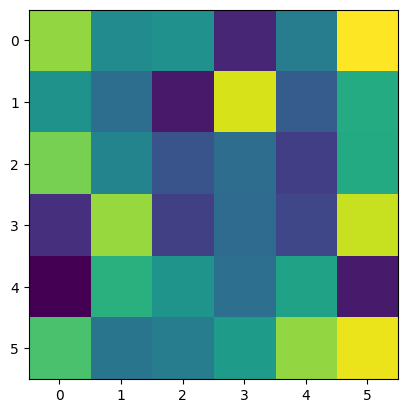

In [13]:
import matplotlib.pyplot as plt

# пример случайной таблицы
matrix = np.random.rand(6, 6)

# цвет характеризует величину
plt.imshow(matrix)